In [1]:
# NOTE: installation of modules is required before running this notebook. (See README.md)
# Also, for plotting, matplotlib is required (run "pip3 install matplotlib" for installation)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from ccpca import CCPCA
from opt_sign_flip import OptSignFlip
from mat_reorder import MatReorder

In [3]:
#
# Example 1 (ccPCA result with Wine dataset)
#

In [4]:
dataset_name = "wine"
data = np.loadtxt(
        open("./sample_data/" + dataset_name + ".csv", "rb"),
        delimiter=",",
        skiprows=1)
feature_names = np.genfromtxt(
    "./sample_data/" + dataset_name + ".featurenames.csv",
    delimiter=",",
    dtype='str')

# last 3 columens are cluster label, t-SNE's x-, and y-coord
X = data[:, :-3]
y = np.int_(data[:, -3])

In [5]:
target_label = 0

# apply ccpca
ccpca = CCPCA(n_components=2)
ccpca.fit_with_best_alpha(
    X[y == target_label],
    X[y != target_label],
    var_thres_ratio=0.5,
    n_alphas=40,
    max_log_alpha=0.5)

# get results
cpca_result = ccpca.transform(X)
best_alpha = ccpca.get_best_alpha()
cpca_fcs = ccpca.get_feat_contribs()

best alpha:  3.1622817516326904
feature contributions:  [-0.56930685  0.00947911 -0.3600359   0.3599595  -0.05803816 -0.14046308
 -0.39541918  0.08502408  0.02142348 -0.10754515 -0.18944907 -0.35198528
 -0.45136067]


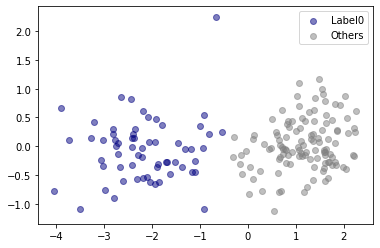

In [6]:
# print and plot results
print("best alpha: ", best_alpha)
print("feature contributions: ",cpca_fcs)
plt.figure()
plt.scatter(
    cpca_result[y == target_label, 0],
    cpca_result[y == target_label, 1],
    color='navy',
    alpha=.5,
    label="Label" + str(target_label))
plt.scatter(
    cpca_result[y != target_label, 0],
    cpca_result[y != target_label, 1],
    color='gray',
    alpha=.5,
    label="Others")
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

In [7]:
#
# Example 2 (features' contributions view with Community & Crime dataset)
#

In [8]:
dataset_name = "crime"
data = np.loadtxt(
        open("./sample_data/" + dataset_name + ".csv", "rb"),
        delimiter=",",
        skiprows=1)
feature_names = np.genfromtxt(
    "./sample_data/" + dataset_name + ".featurenames.csv",
    delimiter=",",
    dtype='str')

X = data[:, :-3]
y = np.int_(data[:, -3])
unique_labels = np.unique(y)

In [9]:
_, n_feats = X.shape
n_labels = len(unique_labels)
first_cpc_mat = np.zeros((n_feats, n_labels))
feat_contrib_mat = np.zeros((n_feats, n_labels))

# 1. get the scaled feature contributions and first cPC for each label
ccpca = CCPCA(n_components=1)
for i, target_label in enumerate(unique_labels):
    ccpca.fit_with_best_alpha(
        X[y == target_label],
        X[y != target_label],
        var_thres_ratio=0.5,
        n_alphas=40,
        max_log_alpha=0.5)

    first_cpc_mat[:, i] = ccpca.get_first_component()
    feat_contrib_mat[:, i] = ccpca.get_scaled_feat_contribs()

# 2. apply optimal sign flipping
OptSignFlip().opt_sign_flip(first_cpc_mat, feat_contrib_mat)

# 3. apply hierarchical clustering with optimal-leaf-ordering
mr = MatReorder()
mr.fit_transform(feat_contrib_mat)

# 4. apply aggregation
n_feats_shown = 25
agg_feat_contrib_mat, label_to_rows, label_to_rep_row = mr.aggregate_rows(feat_contrib_mat,
                                                                          n_feats_shown,
                                                                          agg_method='abs_max')

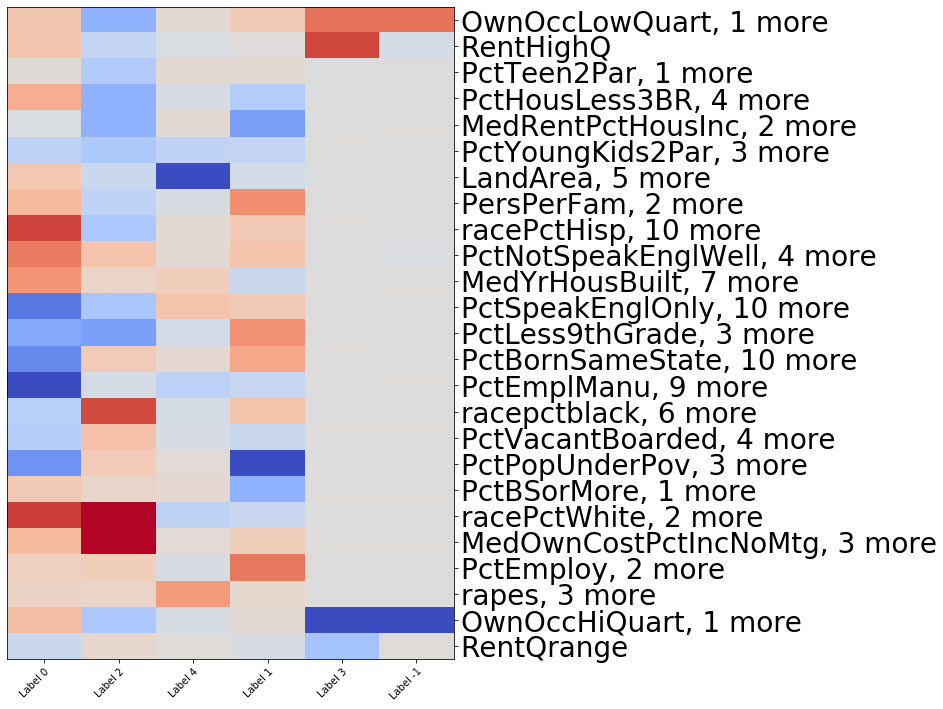

In [10]:
# plot result

# plot heatmap
fig, ax = plt.subplots(figsize=(8, 12))
im = ax.imshow(agg_feat_contrib_mat, cmap='coolwarm', aspect='auto')

# plot cluster names
xlabel_names = [None] * n_labels
for i, col in enumerate(mr.order_col_):
    xlabel_names[i] = 'Label ' + str(unique_labels[col])
ax.set_xticks(np.arange(n_labels))
ax.set_xticklabels(xlabel_names)

# plot feature names
ylabel_names = np.array(feature_names)[mr.order_row_]
ylabel_names = np.array(feature_names, dtype=object)[label_to_rep_row]
for i in range(len(ylabel_names)):
    name = ylabel_names[i]
    rows = label_to_rows[i]
    if len(rows) > 1:
        ylabel_names[i] = name + ', ' + str(len(rows) - 1) + ' more'
ax.set_yticks(np.arange(min(n_feats_shown, n_feats)))
ax.yaxis.tick_right()
ax.set_yticklabels(ylabel_names, fontsize=28)

# rotate the tick labels
xlbls = ax.get_xticklabels()
plt.setp(xlbls, rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()